In [48]:
import json
import os
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.externals import joblib
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import CustomObjectScope

In [49]:
def get_models_paths(folder):
    files = os.listdir(folder)
    files.sort()
    files = ["{}/{}".format(folder, file) for file in files if not file.startswith(".")]
    return files

In [50]:
models_json = get_models_paths("trained_model_files/angles/JSON")
print("\n".join("{}: {}".format(*k) for k in enumerate(models_json)))

0: trained_model_files/angles/JSON/TMA.json
1: trained_model_files/angles/JSON/TMA_v10_DI_PA_different_neurons_Adagrad_30_.json
2: trained_model_files/angles/JSON/TMA_v11_DI_PA_different_neurons_Adadelta_2.3_.json
3: trained_model_files/angles/JSON/TMA_v12_DI_PA_different_neurons_Adamax_47_.json
4: trained_model_files/angles/JSON/TMA_v13_DI_PA_different_neurons_Nadam_0.2_.json
5: trained_model_files/angles/JSON/TMA_v14_DI_PA_different_neurons_RMSProp_35_.json
6: trained_model_files/angles/JSON/TMA_v15_DI_PA_different_neurons_SGD_26_.json
7: trained_model_files/angles/JSON/TMA_v16_DI_PA_different_neurons_and_layouts_4Conv_53_.json
8: trained_model_files/angles/JSON/TMA_v17_DI_PA_different_neurons_and_layouts_4Conv_differentFM_63_.json
9: trained_model_files/angles/JSON/TMA_v18_DI_PA_DN_and_L_PM_VGG16_20.15_.json
10: trained_model_files/angles/JSON/TMA_v19_DI_PA_DN_and_L_PM_VGG19_16.04_.json
11: trained_model_files/angles/JSON/TMA_v2.json
12: trained_model_files/angles/JSON/TMA_v20_DI_PA

In [51]:
models_h5 = get_models_paths("trained_model_files/angles/H5")
print("\n".join("{}: {}".format(*k) for k in enumerate(models_h5)))

0: trained_model_files/angles/H5/TMWA.h5
1: trained_model_files/angles/H5/TMWA_v10_DI_PA_different_neurons_Adagrad_30_.h5
2: trained_model_files/angles/H5/TMWA_v11_DI_PA_different_neurons_Adadelta_2.3_.h5
3: trained_model_files/angles/H5/TMWA_v12_DI_PA_different_neurons_Adamax_47_.h5
4: trained_model_files/angles/H5/TMWA_v13_DI_PA_different_neurons_Nadam_0.2_.h5
5: trained_model_files/angles/H5/TMWA_v14_DI_PA_different_neurons_RMSProp_35_.h5
6: trained_model_files/angles/H5/TMWA_v15_DI_PA_different_neurons_SGD_26_.h5
7: trained_model_files/angles/H5/TMWA_v16_DI_PA_different_neurons_and_layouts_4Conv_53_.h5
8: trained_model_files/angles/H5/TMWA_v17_DI_PA_different_neurons_and_layouts_4Conv_differentFM_63_.h5
9: trained_model_files/angles/H5/TMWA_v18_DI_PA_DN_and_L_PM_VGG16_20.15_.h5
10: trained_model_files/angles/H5/TMWA_v19_DI_PA_DN_and_L_PM_VGG19_16.04_.h5
11: trained_model_files/angles/H5/TMWA_v2.h5
12: trained_model_files/angles/H5/TMWA_v20_DI_PA_DN_and_L_PM_Xception_9.44_.h5
13: tr

In [52]:
CATEGORIES_INT = [i for i in range(1, 361)]
CATEGORIES = [str(item) for item in CATEGORIES_INT]
# map(str, CATEGORIES)
# print(CATEGORIES)

In [53]:
def prepare(filepath):
    IMG_SIZE = 100  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_array = img_array / 255
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [54]:
json_file = open(models_json[25], "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(models_h5[25])
loaded_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

<PIL.Image.Image image mode=RGB size=100x100 at 0x7F1AD18503C8>


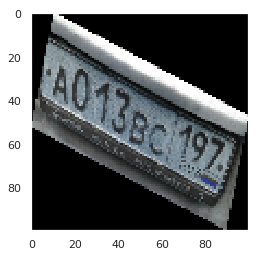

In [111]:
img_path = "im_base_to_angle/DI_PA_Test/test/342/f6b85cda2676486991064d9d90a78097.png"
img = image.load_img(img_path, target_size=(100, 100))
print(img)
plt.grid(False)
plt.imshow(img)

In [89]:
prediction = loaded_model.predict(prepare(img_path))
print(prediction)

[[6.20458884e-14 6.36698539e-14 2.69837948e-14 3.08005337e-14
  5.68445979e-14 8.92948028e-14 2.52875628e-13 8.86699351e-13
  1.57308498e-12 2.31105282e-12 3.13835438e-13 3.10032287e-14
  3.12056382e-15 7.50436728e-16 2.84617660e-15 9.99040951e-16
  1.01889689e-15 6.93632898e-16 1.89619284e-16 1.82453792e-17
  3.82350548e-18 2.16313305e-17 1.40002754e-16 2.12946783e-16
  1.86380050e-15 3.47131942e-16 4.85043570e-16 3.99773611e-16
  6.43520311e-16 4.23159534e-15 1.98348286e-15 1.54144760e-15
  4.71920976e-15 9.40520109e-14 9.65735331e-14 4.79664106e-13
  3.10525870e-14 1.19038887e-15 4.49045418e-17 1.13375582e-15
  1.30769499e-16 8.31335210e-18 5.40372874e-16 7.39343561e-16
  6.94080955e-14 4.36172203e-13 3.11277798e-14 3.40630859e-16
  1.02682495e-16 8.56564318e-17 3.05002771e-18 1.55370757e-17
  5.96608914e-17 5.64927195e-16 5.80219534e-14 6.31889204e-15
  5.91772496e-15 8.99736438e-15 2.03499513e-14 1.01224022e-13
  1.67299833e-12 4.40882899e-13 2.85830963e-14 1.71979928e-15
  3.9519

In [90]:
print(CATEGORIES[np.argmax(prediction)])

342


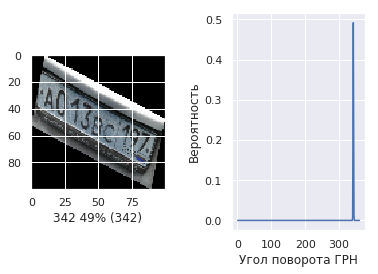

In [150]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.5)
d = {"Угол поворота ГРН": CATEGORIES_INT, "Вероятность": prediction[0]}
pdnumval = pd.DataFrame(d)
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.xlabel(
        "{} {:2.0f}% ({})".format(
            CATEGORIES[np.argmax(prediction)],
            100 * np.max(prediction),
            CATEGORIES[y[1] - 1],
        )
)
fig.add_subplot(1, 2, 2)
sns.set(style="darkgrid")
sns.lineplot(x="Угол поворота ГРН", y="Вероятность", data=pdnumval)

In [96]:
filename = "trained_data/X_4_di_pa_3ch_test.sav"
X = joblib.load(filename)
# print(X[2])
# pickle_in = open("trained_data/X_4_di_pa.pickle","rb")
# X = pickle.load(pickle_in)

In [102]:
# print(X[0])

In [97]:
filename = "trained_data/y_4_di_pa_3ch_test.sav"
y = joblib.load(filename)
# pickle_in = open("trained_data/y_4_di_pa.pickle","rb")
# y = pickle.load(pickle_in)

#### Training set

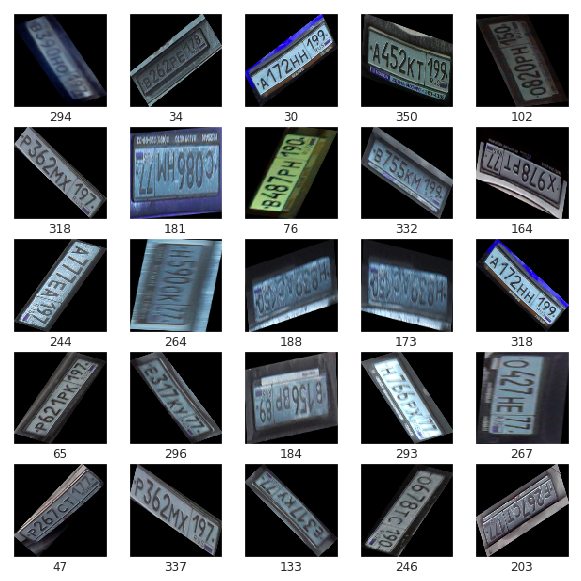

In [45]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

#### Test set

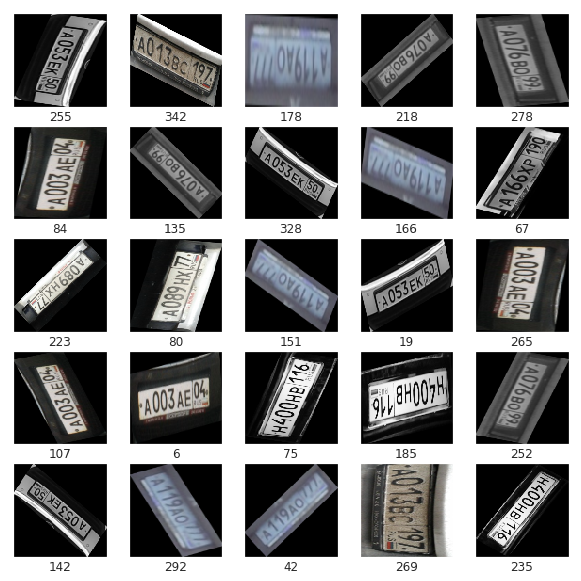

In [94]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

In [104]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label - 1:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            CATEGORIES[predicted_label],
            100 * np.max(predictions_array),
            CATEGORIES[true_label - 1],
        ),
        color=color,
    )


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(CATEGORIES)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

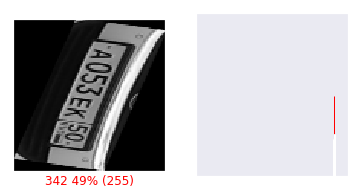

In [106]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, prediction, y, X)
plt.subplot(1,2,2)
plot_value_array(i, prediction,  y)